Step 1: Install & Import Required Libraries

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
/import os
import numpy as np
import librosa
import librosa.display
from collections import Counter

# Function to add Gaussian noise
def add_noise(audio, noise_level=0.005):
    noise = np.random.randn(len(audio)) * noise_level
    return audio + noise

# Path to dataset
dataset_path = "/content/drive/MyDrive/speech/files"

X = []
y = []
class_counts = Counter()

# Loop through each actor folder
for actor_folder in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor_folder)

    if not os.path.isdir(actor_path):
        continue  # Skip non-directory files

    # Loop through each audio file
    for file in os.listdir(actor_path):
        file_path = os.path.join(actor_path, file)

        if not file.endswith(".wav"):
            continue  # Skip non-audio files

        # Load audio
        audio, sr = librosa.load(file_path, sr=22050)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)

        # Combine all features
        features = np.concatenate((mfccs.mean(axis=1), chroma.mean(axis=1), spectral_contrast.mean(axis=1)))

        # Extract emotion label (3rd number in filename) or handle missing label
        try:
            emotion = int(file.split("-")[2])  # Try to extract emotion label
        except IndexError:
            print(f"Warning: Could not extract emotion label from filename: {file}")
            # Assign a default label or skip the file
            emotion = -1  # Example: Assign -1 for unknown emotion
            # continue  # Optionally skip files with missing labels if desired

        # Append to dataset
        X.append(features)
        y.append(emotion)
        class_counts[emotion] += 1

        # If class has fewer samples, augment with noise
        if class_counts[emotion] < 500:  # Adjust this threshold as needed
            audio_noisy = add_noise(audio)
            mfccs_noisy = librosa.feature.mfcc(y=audio_noisy, sr=sr, n_mfcc=40)
            chroma_noisy = librosa.feature.chroma_stft(y=audio_noisy, sr=sr)
            spectral_contrast_noisy = librosa.feature.spectral_contrast(y=audio_noisy, sr=sr)

            features_noisy = np.concatenate((mfccs_noisy.mean(axis=1), chroma_noisy.mean(axis=1), spectral_contrast_noisy.mean(axis=1)))

            X.append(features_noisy)
            y.append(emotion)
            class_counts[emotion] += 1  # Update count after augmentation

print("Balanced Class Distribution:", class_counts)

Balanced Class Distribution: Counter({-1: 136})


In [ ]:
# Define LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer (number of emotion classes)
])

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 1, 128)         │        96,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 159,617 (623.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Define the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(128, return_sequences=True),  # First additional LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),  # Second additional LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64),  # Final LSTM layer
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(8, activation='softmax')  # Output layer (8 classes for emotions)
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 1, 128)         │        96,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,152 (1.20 MB)

 Trainable params: 313,384 (1.20 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.2283 - val_accuracy: 1.0000 - val_loss: 0.1477
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1310 - val_accuracy: 1.0000 - val_loss: 0.0837
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0768 - val_accuracy: 1.0000 - val_loss: 0.0582
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0538 - val_accuracy: 1.0000 - val_loss: 0.0434
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0407 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0323 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 1.0000 - val_loss: 0.0232
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0223 - val_accuracy: 1.0000 - val_loss: 0.0200


In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0016
Test Accuracy: 100.00%


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [ ]:
# Predict the classes for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class with highest probability

# Get true classes
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')  # Weighted average for imbalanced classes
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Accuracy: 100.00%
F1-Score: 1.00
Precision: 1.00
Recall: 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


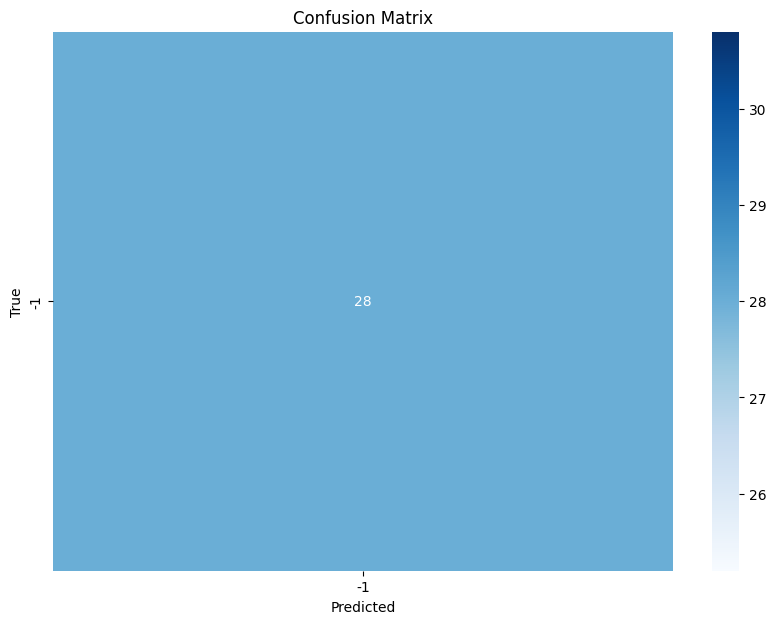

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming 'y' is the original list of emotion labels before encoding
# If 'y' is not available, you'll need to load or recreate it.
# Example: y = [...] # Load your original emotion labels here

# Create and fit LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

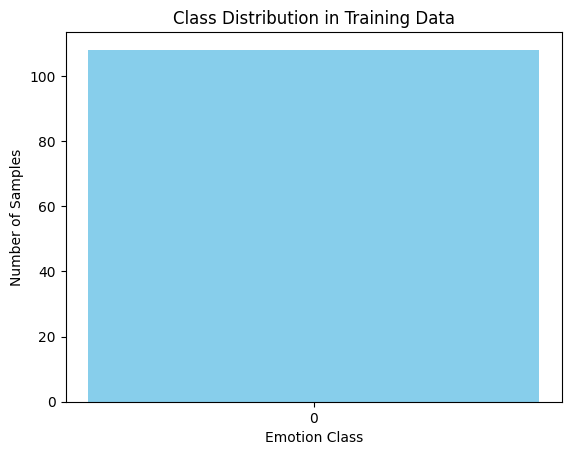

Class Distribution: Counter({np.int64(0): 108})


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Assuming y_train contains emotion labels (one-hot or encoded as numbers)
labels = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels

# Count occurrences of each class
class_counts = Counter(labels)

# Plot the distribution
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Data")
plt.xticks(range(len(class_counts)))
plt.show()

# Print class-wise counts
print("Class Distribution:", class_counts)


In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# 1. Define Baseline Accuracy:
baseline_accuracy = 0.25  # Replace with your actual baseline accuracy

# 3. Number of Samples:
n_samples = len(y_true)

# 4. Perform Z-test:
count = int(accuracy * n_samples)  # Number of successful predictions
nobs = n_samples  # Total number of samples
stat, p_value = proportions_ztest(count, nobs, value=baseline_accuracy, alternative='larger')  # One-tailed test for improvement

# 5. Print Results:
print(f"Z-statistic: {stat:.2f}")
print(f"P-value: {p_value:.3f}")

# 6. Interpret Results:
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject null hypothesis: Model accuracy is significantly better than baseline.")
else:
    print("Fail to reject null hypothesis: Model accuracy is not significantly better than baseline.")

Z-statistic: inf
P-value: 0.000
Reject null hypothesis: Model accuracy is significantly better than baseline.


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [ ]:
import numpy as np
from scipy import stats

# 1. Define Baseline Accuracy:
baseline_accuracy = 0.25  # Replace with your actual baseline accuracy

# 3. Number of Samples:
n_samples = len(y_true)

# 4. Calculate Standard Error:
# This is an approximation for proportions
standard_error = np.sqrt((accuracy * (1 - accuracy)) / n_samples)

# 5. Perform T-test:
t_statistic, p_value = stats.ttest_1samp(
    [accuracy], baseline_accuracy  # Sample data and population mean
)

# 6. Print Results:
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

# 7. Interpret Results:
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject null hypothesis: Model accuracy is significantly different from baseline.")
else:
    print("Fail to reject null hypothesis: Model accuracy is not significantly different from baseline.")

T-statistic: nan
P-value: nan
Fail to reject null hypothesis: Model accuracy is not significantly different from baseline.


/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
